# SIADS591 - Milestone I - Project
## Exploring the Factors Impacting a Movie's Profitability
Team Members:
Charith Tammineedi ( charith@umich.edu ), Carlo Tak ( carlotak@umich.edu )
### Machine Learning  - Classification

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# from feature_importance import FeatureImportance

from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix, confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings('ignore') 

from itertools import compress

from datetime import datetime

We declare some variables that will be used throught this notebook.

In [2]:
# Colors
RED_1 = "#e9292f"
RED_2 = "#bb2326"
RED_3 = "#8c0c04"
RED_4 = "#690902"
RED_5 = "#410601"
RED_6 = "#340400"

The prepared data is imported:

In [3]:
save_dir = "../../Output/"
imdb_dummies_df = pd.read_csv(save_dir + "imdb_dummies_df_2020_09_24.csv", sep="|")
print("imdb_dummies_df.shape :", imdb_dummies_df.shape)
cols = list(imdb_dummies_df.columns)
print("cols :", cols[:10])

imdb_dummies_df.shape : (4782, 29515)
cols : ['tconst', 'primaryTitle', 'originalTitle', 'startYear', 'imdb_id', 'revenue', 'budget', 'runtime', 'release_date', 'popularity']


A function is defined that prepares the data for machine learning.

In [4]:
def get_classification_data(dummies_df, budget_threshold, profitability_threshold,
                            rnd_st=21121,
                            drop_cols = ["primaryTitle", "originalTitle", "imdb_id", "revenue", "profitability", "startYear", "release_date"],
                            profitability_class_threshold=0.5, test_size=0.2, verbose=False):
    ml_df = dummies_df.copy()
    ml_df["profitability"] = (ml_df["revenue"] -  ml_df["budget"]) / ml_df["budget"]
    ml_df = ml_df[(ml_df["budget"] > budget_threshold) & \
                  (ml_df["profitability"] < profitability_threshold)]

    ml_df["release_date"] = pd.to_datetime(ml_df["release_date"])
    ml_df["release_date_month_str"] = pd.DatetimeIndex(ml_df["release_date"]).strftime("%b")
    ml_df["release_date_year"] = pd.DatetimeIndex(ml_df["release_date"]).strftime("%Y")
    
    ml_df["profitable"] = np.where(ml_df["profitability"] > profitability_class_threshold, 1, 0)

    ml_df.drop(drop_cols, axis="columns", inplace=True)
    ml_df.set_index("tconst", inplace=True)
    ml_df = ml_df.fillna(0)
    
    y = ml_df["profitable"]
    X = ml_df.drop(["profitable"], axis="columns")

    features = list(X.columns)
    if "revenue" in features:
        print("revenue in features!")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=rnd_st, stratify=y)
    # print("X_train.shape : {}, X_test.shape : {}, y_train.shape : {}, y_test.shape : {}" \
    #       .format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
    
    if verbose:
        print("y.value_counts() :")
        print(y.value_counts())
        print("y.shape :", y.shape)
        print("X.shape :", X.shape)
        print("ml_df.columns :", list(ml_df.columns)[:5])
        print("ml_df.columns :", list(ml_df.columns)[-5:])
#         print("X.head() :")
#         print(X.head(1))
    return X_train, X_test, y_train, y_test

A function is defined to test a number of classification algorithms to find the best fitting (best predictions).

In [5]:
# Classifiers

def run_classifiers(X_train, X_test, y_train, y_test, 
                    no_classifiers, k_feat=[100], rnd_st=1214,
                    numeric_cols=["runtime", "budget", "popularity"],
                    categorical_cols=["release_date_month_str", "release_date_year"],
                    plot_width=10, scoring_metric="roc_auc"):
    if no_classifiers < 1:
        no_classifiers = 1
    elif no_classifiers > 11:
        no_classifiers = 11
    
    print("no_classifiers :", no_classifiers)
    print("SCORING_METRIC :", scoring_metric)

    trans = [("num", MinMaxScaler(), numeric_cols), 
             ("cat", OneHotEncoder(), categorical_cols)
            ]
    col_transform = ColumnTransformer(transformers=trans, remainder="passthrough")

    pipeline = Pipeline(steps=[("prep", col_transform), 
                               ("feat", SelectKBest()),
                               ("estimator", GaussianNB())])

    est_list = [
                "GaussianNB", 
                "GaussianNB", 

                "MultinomialNB",
                "MultinomialNB",

                "BernoulliNB",
                "BernoulliNB",

                "QuadraticDiscriminantAnalysis", 
                "QuadraticDiscriminantAnalysis", 

                "KNeighborsClassifier", 
                "KNeighborsClassifier", 

                "SVC",
                "SVC",

                "SVC", 
                "SVC",

                "SVC",
                "SVC",

                "DecisionTreeClassifier",
                "DecisionTreeClassifier",   

                "RandomForestClassifier",
                "RandomForestClassifier",    

                "AdaBoostClassifier",
                "AdaBoostClassifier",

    #             "MLPClassifier"
    #             "MLPClassifier"
               ]
    
    est_list = est_list[: 2*no_classifiers]
    
    grid_dict = [
                 {"estimator": [GaussianNB()],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [MultinomialNB()],
                  "estimator__alpha": [0.1, 1.0, 10.0],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [BernoulliNB()],
                  "estimator__alpha": [0.1, 1.0, 10.0],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [QuadraticDiscriminantAnalysis()],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [KNeighborsClassifier()],
                  "estimator__n_neighbors": [3, 5, 7, 9, 11], 
                  "estimator__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [SVC()],
                  "estimator__C": [0.1, 1.0, 10.0, 100.0], 
                  "estimator__kernel": ["poly"],
                  "estimator__degree": [2, 3, 4, 5],
                  "estimator__gamma": ["scale", "auto"],
                  "estimator__probability": [True],
                  "estimator__max_iter": [500000],
                  "estimator__random_state": [rnd_st],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [SVC()],
                  "estimator__C": [1, 10, 100], 
                  "estimator__kernel": ["rbf", "sigmoid"],
                  "estimator__gamma": ["scale", "auto"],
                  "estimator__probability": [True],
                  "estimator__max_iter": [500000],
                  "estimator__random_state": [rnd_st],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [SVC()],
                  "estimator__kernel": ["linear"],
                  "estimator__C": [1, 10, 100], 
                  "estimator__max_iter": [500000],
                  "estimator__probability": [True],
                  "estimator__random_state": [rnd_st],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },   
                 {"estimator": [DecisionTreeClassifier()],
                  "estimator__criterion": ["gini", "entropy"],
                  "estimator__splitter": ["best", "random"],             
                  "estimator__max_depth": [None, 3, 5, 8], 
                  "estimator__max_features": ["auto", "sqrt", "log2"],
                  "estimator__random_state": [rnd_st],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [RandomForestClassifier()],
                  "estimator__n_estimators": [100, 500, 1000],
                  "estimator__criterion": ["gini", "entropy"],       
                  "estimator__max_depth": [None, 3, 5, 8], 
                  "estimator__max_features": ["auto", "sqrt", "log2"],
                  "estimator__random_state": [rnd_st],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [AdaBoostClassifier()],
                  "estimator__base_estimator": [DecisionTreeClassifier()],
                  "estimator__base_estimator__max_depth": [1, 3],
                  "estimator__n_estimators": [50, 100, 500, 1000],
                  "estimator__learning_rate": [0.1, 1.0, 10.0],       
                  "estimator__random_state": [rnd_st],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
    #              {"estimator": [MLPClassifier()],
    #               "estimator__hidden_layer_sizes": [(400, 400)], # (300, 300) causes PC crash
    #               "estimator__activation": ["relu"], #["identity", "logistic", "tanh", "relu"]
    #               "estimator__solver": ["adam"], #["lbfgs", "sgd", "adam"]
    #               "estimator__alpha": [0.0001],#[0.0001, 0.001, 0.01],  
    #               "estimator__batch_size": [10],
    #               "feat__k": k_feat,
#                   "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
    #              }
                ]
    grid_dict = grid_dict[:no_classifiers]
    
    idx = 1
    plt.clf()
    fig, axes = plt.subplots(nrows=no_classifiers, ncols=2, 
                             figsize=(plot_width, plot_width * no_classifiers / 2.25))
    # print("len(axes) :", len(axes))
    # print("len(axes.flatten()) :", len(axes.flatten()))
    fitted_classifiers = []
    for  grid in grid_dict:
    #     print("name :", name)
    #     print("grid :", grid)
        grid = GridSearchCV(estimator=pipeline, param_grid=grid, scoring=scoring_metric, cv=5) # , n_jobs=2

        grid.fit(X_train, y_train)
        fitted_classifiers.append(grid)
        fitted_classifiers.append(grid)
        
    for name, grid, ax in zip(est_list, fitted_classifiers, axes.flatten()):
    #     print("Processing {}, {}, {} :".format(name, grid, ax))


    #     print("Processing idx-{}".format(idx))
        if idx % 2 != 0:       
            best_params = grid.best_params_
            print("********************************{}*********************************".format(name))
            print("best_params :", best_params)

            y_test_pred_proba = grid.predict_proba(X_test)[::,1]
            y_train_pred_proba = grid.predict_proba(X_train)[::,1]
            fpr, tpr, _ = roc_curve(y_test,  y_test_pred_proba)
            y_train_pred = grid.predict(X_train)
            y_test_pred = grid.predict(X_test)
            score_train = grid.score(X_train, y_train)
            score_test = grid.score(X_test, y_test)
            print("score_train :", score_train)
            print("score_test :", score_test)
            accuracy_score_train = accuracy_score(y_train, y_train_pred)
            accuracy_score_test = accuracy_score(y_test, y_test_pred)
            print("accuracy_score_train :", score_train)
            print("accuracy_score_test :", score_test)
            auc_score_train = roc_auc_score(y_train, y_train_pred_proba)
            auc_score_test = roc_auc_score(y_test, y_test_pred_proba)
            print("auc_score_train :", auc_score_train)
            print("auc_score_test :", auc_score_test)
            con_matrix = confusion_matrix(y_test, y_test_pred)
            print("con_matrix :")
            print(con_matrix)
            manual_accuracy = (con_matrix[0][0] + con_matrix[1][1]) / (con_matrix[0][0] + con_matrix[1][1] + con_matrix[0][1] + con_matrix[1][0])
            print("manual_accuracy :", manual_accuracy)

            ax.plot(fpr, tpr, linewidth=3, color="orange", 
                 label="ROC curve (auc={:.2f})".format(auc_score_test))
            ax_min = min([min(y_test_pred), min(y_test)])
            ax_max = max([max(y_test_pred), max(y_test)])
            ax.set_title("{} - ROC Curve".format(name), fontsize=12)
            ax.plot([ax_min, ax_max], [ax_min, ax_max], 
                     linewidth=3, linestyle="--", 
                     color="grey", label="Random guess")
            ax.set_xlim(ax_min, ax_max)
            ax.set_ylim(ax_min, ax_max)
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend(loc=4)
        else:    
            plot_confusion_matrix(
                                  grid, 
                                  X_test, y_test, 
                                  ax=ax, 
                                  cmap="Blues", 
                                  values_format="d",
                                  display_labels=["Not profitable", "profitable"]
                                 )
            ax.set_title("{} - Confusion Matrix".format(name), fontsize=12)

            print("***************************************************************************************")

        idx += 1



    plt.tight_layout()
    plt.show()
    return "Run complete"

Now, we perform a run across many different classifiers (algorithms) to see which algorithm gives the best performance. Many algorithms as well as hyperparameter combinations are tested, so this step is computationally intensive - it will take a lot of time to calculate.

The parameters of the run can also be altered in the cell bellow. things like the profitability class threshold (PROFITABILITY_CLASS_THRESHOLD)  can be adjusted.

y.value_counts() :
0    1801
1    1392
Name: profitable, dtype: int64
y.shape : (3193,)
X.shape : (3193, 29510)
ml_df.columns : ['budget', 'runtime', 'popularity', 'director__A.R. Murugadoss', 'director__Aanand L. Rai']
ml_df.columns : ['writer__Éric Toledano', 'writer__Óskar Jónasson', 'release_date_month_str', 'release_date_year', 'profitable']
no_classifiers : 2
SCORING_METRIC : roc_auc
********************************GaussianNB*********************************
best_params : {'estimator': GaussianNB(priors=None, var_smoothing=1e-09), 'feat__k': 100, 'feat__score_func': <function f_classif at 0x00000193912830D0>}
score_train : 0.7429423761700875
score_test : 0.612042015133413
accuracy_score_train : 0.7429423761700875
accuracy_score_test : 0.612042015133413
auc_score_train : 0.7429423761700875
auc_score_test : 0.612042015133413
con_matrix :
[[341  19]
 [237  42]]
manual_accuracy : 0.5993740219092332
**************************************************************************************

<Figure size 432x288 with 0 Axes>

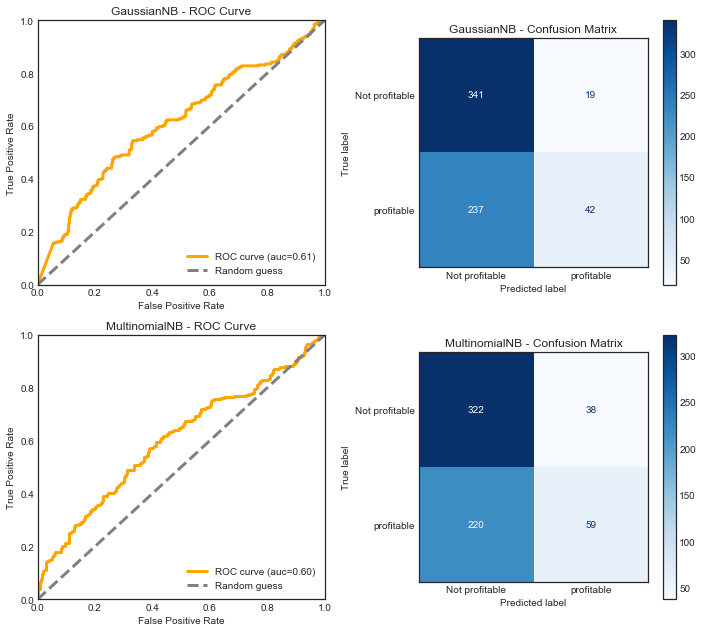

'Run complete'

In [6]:
NO_CLASSIFIERS = 2
PLOT_WIDTH = 10
SCORING_METRIC = "roc_auc" #"roc_auc", "accuracy", "precision", "recall"

BUDGET_THRESHOLD = 10000             # Larger values reduce the data set size
PROFITABILITY_THRESHOLD = 2.0        # Larger values increase the data set size
PROFITABILITY_CLASS_THRESHOLD = 0.24
RND_ST = 54879

start_time = datetime.now()
print("*"*10, "Process started @", start_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)

X_train, X_test, y_train, y_test = \
    get_classification_data(dummies_df=imdb_dummies_df, budget_threshold=BUDGET_THRESHOLD, 
                            rnd_st=RND_ST,
                            drop_cols = ["primaryTitle", "originalTitle", "imdb_id", "revenue", "profitability", "startYear", "release_date"],
                            profitability_threshold=PROFITABILITY_THRESHOLD,
                            profitability_class_threshold=PROFITABILITY_CLASS_THRESHOLD, 
                            test_size=0.2, verbose=True)

run_classifiers(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, 
                k_feat=[100], rnd_st=RND_ST,
                numeric_cols=["runtime", "budget", "popularity"],
                categorical_cols=["release_date_month_str", "release_date_year"],
                no_classifiers=NO_CLASSIFIERS, plot_width=PLOT_WIDTH, scoring_metric=SCORING_METRIC)

end_time = datetime.now()
print("*"*10, "Process ended @", end_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)
duration = end_time - start_time
print("*"*10, "Duration -", duration, "*"*50)

The run is repeated, but the profitability class threshold (PROFITABILITY_CLASS_THRESHOLD) is changed.

y.value_counts() :
0    2053
1    1140
Name: profitable, dtype: int64
y.shape : (3193,)
X.shape : (3193, 29510)
ml_df.columns : ['budget', 'runtime', 'popularity', 'director__A.R. Murugadoss', 'director__Aanand L. Rai']
ml_df.columns : ['writer__Éric Toledano', 'writer__Óskar Jónasson', 'release_date_month_str', 'release_date_year', 'profitable']
no_classifiers : 2
SCORING_METRIC : roc_auc
********************************GaussianNB*********************************
best_params : {'estimator': GaussianNB(priors=None, var_smoothing=1e-09), 'feat__k': 100, 'feat__score_func': <function f_classif at 0x00000193912830D0>}
score_train : 0.7249870451097293
score_test : 0.6443366628249456
accuracy_score_train : 0.7249870451097293
accuracy_score_test : 0.6443366628249456
auc_score_train : 0.7249870451097293
auc_score_test : 0.6443366628249456
con_matrix :
[[387  24]
 [199  29]]
manual_accuracy : 0.651017214397496
************************************************************************************

<Figure size 432x288 with 0 Axes>

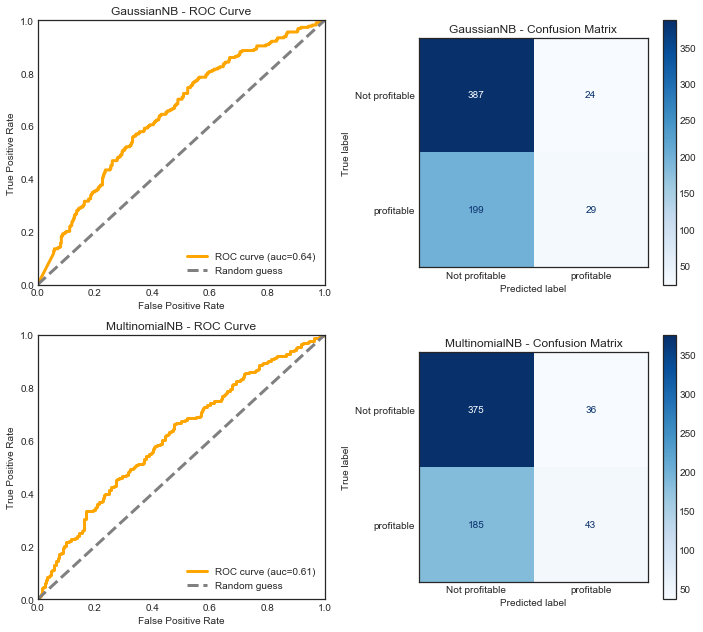

'Run complete'

In [7]:
NO_CLASSIFIERS = 2
PLOT_WIDTH = 10
SCORING_METRIC = "roc_auc" #"roc_auc", "accuracy", "precision", "recall"

BUDGET_THRESHOLD = 10000             # Larger values reduce the data set size
PROFITABILITY_THRESHOLD = 2.0        # Larger values increase the data set size
PROFITABILITY_CLASS_THRESHOLD = 0.50
RND_ST = 54879

start_time = datetime.now()
print("*"*10, "Process started @", start_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)

X_train, X_test, y_train, y_test = \
    get_classification_data(dummies_df=imdb_dummies_df, budget_threshold=BUDGET_THRESHOLD, 
                            rnd_st=RND_ST,
                            drop_cols = ["primaryTitle", "originalTitle", "imdb_id", "revenue", "profitability", "startYear", "release_date"],
                            profitability_threshold=PROFITABILITY_THRESHOLD,
                            profitability_class_threshold=PROFITABILITY_CLASS_THRESHOLD, 
                            test_size=0.2, verbose=True)

run_classifiers(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, 
                k_feat=[100], rnd_st=RND_ST,
                numeric_cols=["runtime", "budget", "popularity"],
                categorical_cols=["release_date_month_str", "release_date_year"],
                no_classifiers=NO_CLASSIFIERS, plot_width=PLOT_WIDTH, scoring_metric=SCORING_METRIC)

end_time = datetime.now()
print("*"*10, "Process ended @", end_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)
duration = end_time - start_time
print("*"*10, "Duration -", duration, "*"*50)

Now, we would also like to see what sort of features were taken into account when building this model. A function is defined below that runs a single estimator (algorithm) and extracts the feature importances.

In [6]:
def run_classifier_with_feature_importances(X_train, X_test, y_train, y_test, 
                                            show_n_features = 10,
                                            k_feat=[100], sample_size=2, rnd_st=1214,
                                            numeric_cols = ["runtime", "budget", "popularity"], 
                                            categorical_cols = ["release_date_month_str", "release_date_year"], 
                                            quick_run=True, 
                                            plot_width=10, scoring_metric="roc_auc"):
    print("SCORING_METRIC :", scoring_metric)


    trans = [("num", MinMaxScaler(), numeric_cols), 
             ("cat", OneHotEncoder(), categorical_cols)
            ]
    col_transform = ColumnTransformer(transformers=trans, remainder="passthrough")

    pipeline = Pipeline(steps=[('prep', col_transform), 
                               ("feat", SelectKBest()),
                               ('estimator', RandomForestClassifier())])   
    
    est_list = [
                "RandomForestClassifier",
                "RandomForestClassifier",   
               ]

    if quick_run:
        grid_dict = [
                     {"estimator": [RandomForestClassifier()],
                      "estimator__n_estimators": [25], #[100, 500, 1000],
                      "estimator__criterion": ["gini"], # ["gini", "entropy"],       
                      "estimator__max_depth": [5], #[None, 3, 5, 8], 
                      "estimator__max_features": ["sqrt"], # ["auto", "sqrt", "log2"],
                      "estimator__random_state": [rnd_st],
                      "feat__k": k_feat,
                      "feat__score_func": [f_classif], #Do not release - compute time is extreme [f_classif, mutual_info_classif, chi2]
                     }
                    ]
    else:
        grid_dict = [
             {"estimator": [RandomForestClassifier()],
              "estimator__n_estimators": [100, 500, 1000, 2000],
              "estimator__criterion": ["gini", "entropy"],       
              "estimator__max_depth": [None, 3, 5, 8], 
              "estimator__max_features": ["auto", "sqrt", "log2"],
              "estimator__random_state": [rnd_st],
              "feat__k": k_feat,
              "feat__score_func": [f_classif], #Do not release - compute time is extreme [f_classif, mutual_info_classif, chi2]
             }
            ]

    feature_names = list(X_train.columns)
    grid = GridSearchCV(estimator=pipeline, param_grid=grid_dict, scoring=scoring_metric, cv=5) # , n_jobs=2

    grid.fit(X_train, y_train)    
    best_params = grid.best_params_
    print("best_params :", best_params)
    
    fitted_column_transformer = grid.best_estimator_.named_steps["prep"]
    fitted_column_transformer_remainder = grid.best_estimator_.named_steps["prep"]
    list_fitted_column_transformer = fitted_column_transformer._iter(fitted=True)
    # print("list_fitted_column_transformer :", list_fitted_column_transformer)
    prep_feature_names = numeric_cols
    for name, trans, column, _ in list_fitted_column_transformer:
        if name == "cat":
            prep_feature_names.extend(trans.get_feature_names())
        elif name == "remainder":
            feature_names_remaining = [feature_names[idx] for idx in column]
            prep_feature_names.extend(feature_names_remaining)
    
    selected_features = grid.best_estimator_.named_steps["feat"].get_support()   
    reduced_features = list(compress(prep_feature_names, selected_features))
    X_sample_transformed_by_col_trans = fitted_column_transformer.transform(X_train.head(sample_size))
    X_sample_transformed_by_col_trans_df = pd.DataFrame(data=X_sample_transformed_by_col_trans,
                                                        columns=prep_feature_names)
    rows, cols = X_sample_transformed_by_col_trans_df.shape

    feature_importances = grid.best_estimator_.named_steps["estimator"].feature_importances_
#     print("feature_importances.shape :", feature_importances.shape)
    feature_importances_df = pd.DataFrame(data=feature_importances, 
                                          index=reduced_features,
                                          columns=["importance"])
    feature_importances_df = feature_importances_df.sort_values("importance", ascending=False)
#     print("feature_importances_df :")
#     print(feature_importances_df.head(25))


    y_test_pred_proba = grid.predict_proba(X_test)[::,1]
    y_train_pred_proba = grid.predict_proba(X_train)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_test_pred_proba)
#     print("fpr :", fpr)
#     print("tpr :", tpr)
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)
    score_train = grid.score(X_train, y_train)
    score_test = grid.score(X_test, y_test)
#     print("score_train :", score_train)
#     print("score_test :", score_test)
    accuracy_score_train = accuracy_score(y_train, y_train_pred)
    accuracy_score_test = accuracy_score(y_test, y_test_pred)
    print("accuracy_score_train :", score_train)
    print("accuracy_score_test :", score_test)
    auc_score_train = roc_auc_score(y_train, y_train_pred_proba)
    auc_score_test = roc_auc_score(y_test, y_test_pred_proba)
    print("auc_score_train :", auc_score_train)
    print("auc_score_test :", auc_score_test)
    con_matrix = confusion_matrix(y_test, y_test_pred)
#     print("con_matrix :")
#     print(con_matrix)
#     manual_accuracy = (con_matrix[0][0] + con_matrix[1][1]) / (con_matrix[0][0] + con_matrix[1][1] + con_matrix[0][1] + con_matrix[1][0])
#     print("manual_accuracy :", manual_accuracy)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(plot_width, plot_width * 1 / 2.25))
    ax[0].plot(fpr, tpr, linewidth=3, color="orange", label="ROC curve (auc={:.2f})".format(auc_score_test))
    ax_min = min([min(y_test_pred), min(y_test)])
    ax_max = max([max(y_test_pred), max(y_test)])
    ax[0].set_title("{} - ROC Curve".format(name), fontsize=16)
    
    ax[0].plot([ax_min, ax_max], [ax_min, ax_max], 
             linewidth=3, linestyle="--", 
             color="grey", label="Random guess")
    ax[0].set_xlim(ax_min, ax_max)
    ax[0].set_ylim(ax_min, ax_max)
    ax[0].set_xlabel("False Positive Rate", fontsize=14)
    ax[0].set_ylabel("True Positive Rate", fontsize=14)
    ax[0].tick_params(axis="x", labelsize=12)
    ax[0].tick_params(axis="y", labelsize=12)
    ax[0].legend(loc=4, fontsize=12)

    plot_confusion_matrix(
                          grid, 
                          X_test, y_test, 
                          ax=ax[1], 
                          cmap="Blues", 
                          values_format="d",
                          display_labels=["Not profitable", "profitable"]
                         )
    ax[1].set_title("{} - Confusion Matrix".format(name), fontsize=16)
    ax[1].tick_params(axis="x", labelsize=12)
    ax[1].tick_params(axis="y", labelsize=12, rotation=90)
    plt.show()
    
    plot_feature_importances_df = feature_importances_df.head(show_n_features)
    plt.figure(figsize=(plot_width, plot_width / 2))
    plt.bar(plot_feature_importances_df.index, plot_feature_importances_df["importance"], color=RED_1)
    plt.xlabel("Feature Name", fontsize=12)
    plt.xticks(fontsize=12, rotation=-90)
    plt.ylabel("Importance", fontsize=14)
    plt.yticks(fontsize=12)
    plt.title("Feature Importances", fontsize=14)
    plt.show()
#     print("***************************************************************************************")
    
    temp_X = X_train.head(sample_size).iloc[:,:-3]
    rows, cols = temp_X.shape
    non_zero_col_idx_df = []
    for row in range(0, 2):
        non_zero_col_idx = []
        for col in range(0, cols):
            temp_value = temp_X.iloc[row, col]
            # print("temp_value :", temp_value)
            try:
                if temp_value > 0:
                    non_zero_col_idx.append(col)
            except:
                print("Skipping - {}".format(temp_value))
    #     print("len(non_zero_col_idx) :", len(non_zero_col_idx))
    #     print("non_zero_col_idx :", non_zero_col_idx)
        non_zero_col_idx_df.extend(list(set(non_zero_col_idx)))
    non_zero_col_idx_df = list(set(non_zero_col_idx_df))
#     print("non_zero_col_idx_df :", non_zero_col_idx_df)
#     print("len(non_zero_col_idx_df) :", len(non_zero_col_idx_df))
    non_zero_cols_X = temp_X.iloc[ : , non_zero_col_idx_df]

    return X_train.head(sample_size), X_sample_transformed_by_col_trans_df, non_zero_cols_X # "Run complete"

Now we fit a model of this data using the RandomForestClassifier estimator (algorithm) from sci-kit learn. The feature importances are also extracted from this algorithm. This gives an indication of what is contributing to the models predictive power.

SCORING_METRIC : roc_auc
best_params : {'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=54879,
                       verbose=0, warm_start=False), 'estimator__criterion': 'gini', 'estimator__max_depth': 5, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 25, 'estimator__random_state': 54879, 'feat__k': 50, 'feat__score_func': <function f_classif at 0x00000193912830D0>}
accuracy_score_train : 0.7405219246642263
accuracy_score_test : 0.7085374352847471
auc_score_train : 0.7405219246642263
auc_score_test : 0.7085374352847471


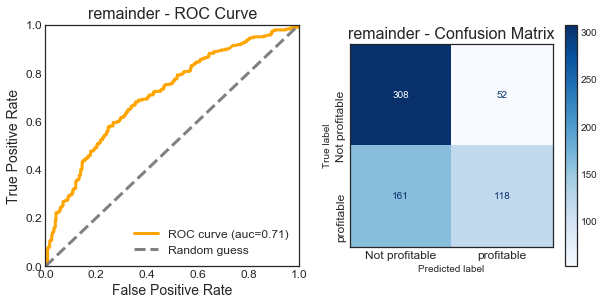

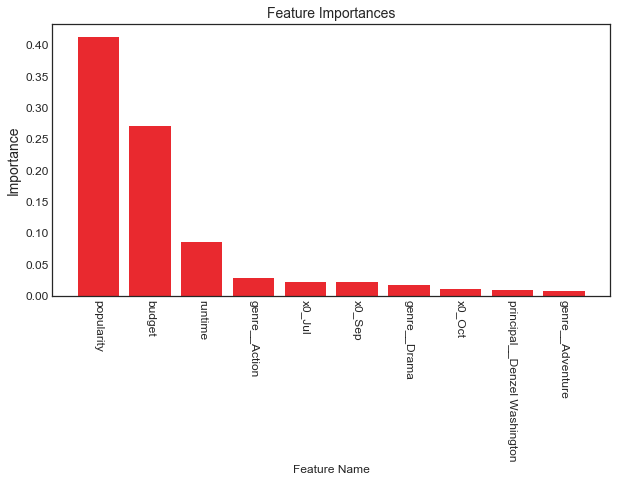

In [9]:
PLOT_WIDTH = 10
SCORING_METRIC = "roc_auc" #"roc_auc", "accuracy", "precision", "recall"

BUDGET_THRESHOLD = 10000             # Larger values reduce the data set size
PROFITABILITY_THRESHOLD = 2.0        # Larger values increase the data set size
PROFITABILITY_CLASS_THRESHOLD = 0.24
RND_ST = 54879
QUICK_RUN = True
DROP_COLS = ["primaryTitle", "originalTitle", "imdb_id", "revenue", "profitability", "startYear", "release_date"]
NUMERIC_COLS = ["runtime", "budget", "popularity"]
CATEGORICAL_COLS = ["release_date_month_str", "release_date_year"]
K_FEAT = [50, 100, 200]

start_time = datetime.now()
print("*"*10, "Process started @", start_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)

X_train, X_test, y_train, y_test = \
    get_classification_data(dummies_df=imdb_dummies_df, budget_threshold=BUDGET_THRESHOLD, 
                            rnd_st=RND_ST,
                            drop_cols = DROP_COLS,
                            profitability_threshold=PROFITABILITY_THRESHOLD,
                            profitability_class_threshold=PROFITABILITY_CLASS_THRESHOLD, 
                            test_size=0.2, verbose=False)

sample_X, sample_trans_X, sample_non_zero_X = \
    run_classifier_with_feature_importances(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, 
                                            show_n_features = 10,
                                            k_feat=K_FEAT, 
                                            sample_size=2, rnd_st=RND_ST,
                                            numeric_cols=NUMERIC_COLS, 
                                            categorical_cols=CATEGORICAL_COLS, 
                                            quick_run=QUICK_RUN, 
                                            plot_width=PLOT_WIDTH, scoring_metric=SCORING_METRIC)

end_time = datetime.now()
print("*"*10, "Process ended @", end_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)
duration = end_time - start_time
print("*"*10, "Duration -", duration, "*"*50)

The results shows the importance of the various features. The most important features are on the left and moving towards the right, the features become less important.

Some interesting features emerge - specific actors (principals) and specific genres.

There is a concern about the 'popularity' feature - the popularity of a movie might only be able to be determined after the movie is released. Therefore it might not be correct to use this feature to predict the profitability of the movie (comes from revenue), which is also determined after the movie is released. If this is true, then this would be an example of data leakage - information from the future used to predict future profitability.

To see the effect that this feature has on the model, the model is run again, but without the feature.

********** Process started @ 28-09-2020, 18:40:52 **************************************************
SCORING_METRIC : roc_auc
best_params : {'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=54879,
                       verbose=0, warm_start=False), 'estimator__criterion': 'gini', 'estimator__max_depth': 5, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 25, 'estimator__random_state': 54879, 'feat__k': 100, 'feat__score_func': <function f_classif at 0x000001D341F950D0>}
accuracy_score_train : 0.6991934322339047
accuracy_score_test 

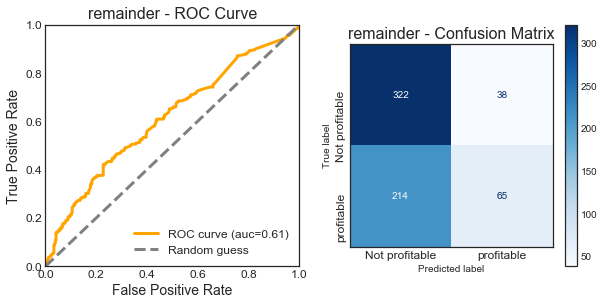

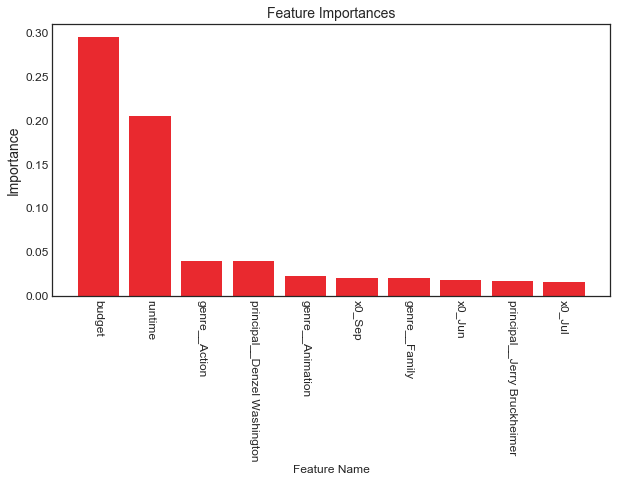

********** Process ended @ 28-09-2020, 18:41:38 **************************************************
********** Duration - 0:00:45.902409 **************************************************


In [8]:
PLOT_WIDTH = 10
SCORING_METRIC = "roc_auc" #"roc_auc", "accuracy", "precision", "recall"

BUDGET_THRESHOLD = 10000             # Larger values reduce the data set size
PROFITABILITY_THRESHOLD = 2.0        # Larger values increase the data set size
PROFITABILITY_CLASS_THRESHOLD = 0.24
RND_ST = 54879
DROP_COLS = ["primaryTitle", "popularity", "originalTitle", "imdb_id", "revenue", "profitability", "startYear", "release_date"]
NUMERIC_COLS = ["runtime", "budget"]
CATEGORICAL_COLS = ["release_date_month_str", "release_date_year"]
K_FEAT = [50, 100, 200]
QUICK_RUN = True

start_time = datetime.now()
print("*"*10, "Process started @", start_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)

X_train, X_test, y_train, y_test = \
    get_classification_data(dummies_df=imdb_dummies_df, budget_threshold=BUDGET_THRESHOLD, 
                            rnd_st=RND_ST,
                            drop_cols = DROP_COLS,
                            profitability_threshold=PROFITABILITY_THRESHOLD,
                            profitability_class_threshold=PROFITABILITY_CLASS_THRESHOLD, 
                            test_size=0.2, verbose=False)

sample_X, sample_trans_X, sample_non_zero_X = \
    run_classifier_with_feature_importances(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, 
                                            show_n_features = 10,
                                            k_feat=K_FEAT, sample_size=2, rnd_st=RND_ST,
                                            numeric_cols = NUMERIC_COLS, 
                                            categorical_cols = CATEGORICAL_COLS, 
                                            quick_run=QUICK_RUN, 
                                            plot_width=PLOT_WIDTH, scoring_metric=SCORING_METRIC)

end_time = datetime.now()
print("*"*10, "Process ended @", end_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)
duration = end_time - start_time
print("*"*10, "Duration -", duration, "*"*50)

It must be kept in mind that the order of the features can change, if the model is re-run with differnt parameters. So, the order of the features in terms of importance should be thought of as an indication, not a fixed order.

It would be interesting to see, what sort of model could be built using features of a specific sub-group. For example, the features above have a mixture of sub-groups (e.g. genres and actors). If a model was built using only the genres, for example, if it performs well, what would the order of the feature importances be?

The above runs were performed with a limit amount of parameters, now a larger amount of parameters are checked to see if the model performance increases. The added number of parameters will increase the amount of computation required, so this will take longer than before.

SCORING_METRIC : roc_auc
best_params : {'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=54879,
                       verbose=0, warm_start=False), 'estimator__criterion': 'gini', 'estimator__max_depth': 8, 'estimator__max_features': 'auto', 'estimator__n_estimators': 100, 'estimator__random_state': 54879, 'feat__k': 100, 'feat__score_func': <function f_classif at 0x00000193912830D0>}
accuracy_score_train : 0.7486134778371564
accuracy_score_test : 0.6185782556750299
auc_score_train : 0.7486134778371564
auc_score_test : 0.6185782556750299


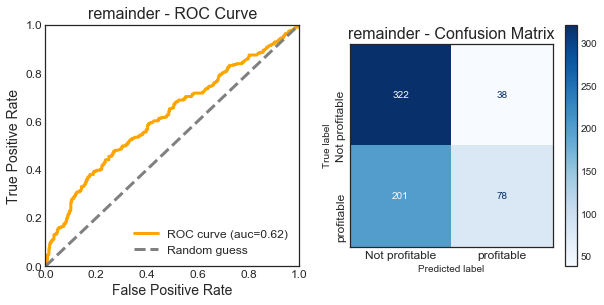

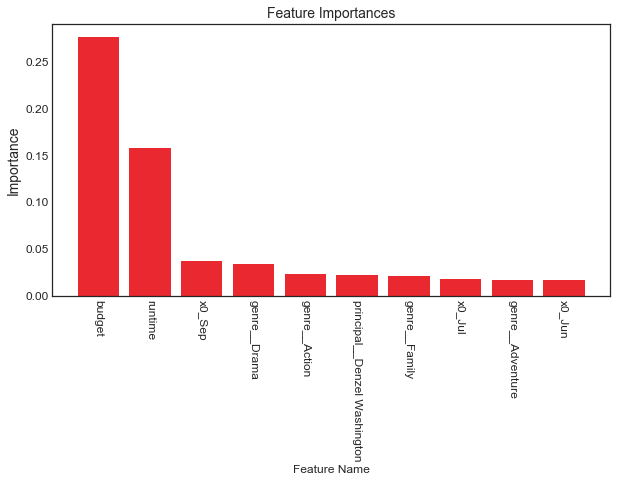

In [12]:
PLOT_WIDTH = 10
SCORING_METRIC = "roc_auc" #"roc_auc", "accuracy", "precision", "recall"

BUDGET_THRESHOLD = 10000             # Larger values reduce the data set size
PROFITABILITY_THRESHOLD = 2.0        # Larger values increase the data set size
PROFITABILITY_CLASS_THRESHOLD = 0.24
RND_ST = 54879
DROP_COLS = ["primaryTitle", "popularity", "originalTitle", "imdb_id", "revenue", "profitability", "startYear", "release_date"]
NUMERIC_COLS = ["runtime", "budget"]
CATEGORICAL_COLS = ["release_date_month_str", "release_date_year"]
K_FEAT=[50, 100, 200]
QUICK_RUN = False
             
start_time = datetime.now()
print("*"*10, "Process started @", start_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)

X_train, X_test, y_train, y_test = \
    get_classification_data(dummies_df=imdb_dummies_df, budget_threshold=BUDGET_THRESHOLD, 
                            rnd_st=RND_ST,
                            drop_cols = DROP_COLS,
                            profitability_threshold=PROFITABILITY_THRESHOLD,
                            profitability_class_threshold=PROFITABILITY_CLASS_THRESHOLD, 
                            test_size=0.2, verbose=False)

sample_X, sample_trans_X, sample_non_zero_X = \
    run_classifier_with_feature_importances(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, 
                                            show_n_features = 10,
                                            k_feat=K_FEAT, sample_size=2, rnd_st=RND_ST,
                                            numeric_cols = NUMERIC_COLS, 
                                            categorical_cols = CATEGORICAL_COLS, 
                                            quick_run=QUICK_RUN, 
                                            plot_width=PLOT_WIDTH, scoring_metric=SCORING_METRIC)

end_time = datetime.now()
print("*"*10, "Process ended @", end_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)
duration = end_time - start_time
print("*"*10, "Duration -", duration, "*"*50)

The ROC curve shows that the model is better than a random guess. The closer the AUC value to 1.0 the better a model is generally performing (bar overfitting to the training data).

'budget' has the highest feature importance. It should be noted that these feature importances are model specific; meaning that if the model is re-run with different parameters, the feature importances might change. Also, it would be good if the model first achieves a good score before making inferences about the feature importances.

A run is also made without the 'budget' value, to see how it effects the model.

SCORING_METRIC : roc_auc
best_params : {'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=54879,
                       verbose=0, warm_start=False), 'estimator__criterion': 'gini', 'estimator__max_depth': 8, 'estimator__max_features': 'auto', 'estimator__n_estimators': 100, 'estimator__random_state': 54879, 'feat__k': 200, 'feat__score_func': <function f_classif at 0x00000193912830D0>}
accuracy_score_train : 0.7455380329498147
accuracy_score_test : 0.6083134209478295
auc_score_train : 0.7455380329498147
auc_score_test : 0.6083134209478295


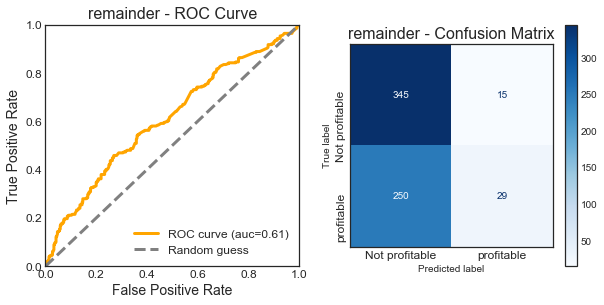

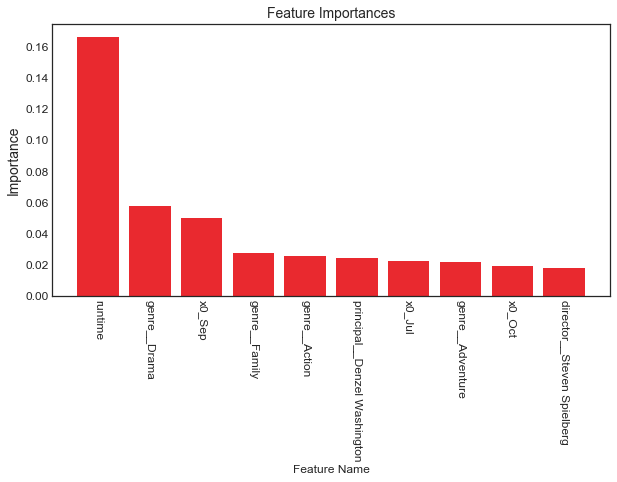

In [14]:
PLOT_WIDTH = 10
SCORING_METRIC = "roc_auc" #"roc_auc", "accuracy", "precision", "recall"

BUDGET_THRESHOLD = 10000             # Larger values reduce the data set size
PROFITABILITY_THRESHOLD = 2.0        # Larger values increase the data set size
PROFITABILITY_CLASS_THRESHOLD = 0.24
RND_ST = 54879
DROP_COLS = ["primaryTitle", "budget", "popularity", "originalTitle", "imdb_id", "revenue", "profitability", "startYear", "release_date"]
NUMERIC_COLS = ["runtime"]
CATEGORICAL_COLS = ["release_date_month_str", "release_date_year"]
K_FEAT=[50, 100, 200]
QUICK_RUN = False
       
start_time = datetime.now()
print("*"*10, "Process started @", start_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)

X_train, X_test, y_train, y_test = \
    get_classification_data(dummies_df=imdb_dummies_df, budget_threshold=BUDGET_THRESHOLD, 
                            rnd_st=RND_ST,
                            drop_cols = DROP_COLS,
                            profitability_threshold=PROFITABILITY_THRESHOLD,
                            profitability_class_threshold=PROFITABILITY_CLASS_THRESHOLD, 
                            test_size=0.2, verbose=False)

sample_X, sample_trans_X, sample_non_zero_X = \
    run_classifier_with_feature_importances(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, 
                                            show_n_features = 10,
                                            k_feat=K_FEAT, sample_size=2, rnd_st=RND_ST,
                                            numeric_cols = NUMERIC_COLS, 
                                            categorical_cols = CATEGORICAL_COLS, 
                                            quick_run=QUICK_RUN, 
                                            plot_width=PLOT_WIDTH, scoring_metric=SCORING_METRIC)

end_time = datetime.now()
print("*"*10, "Process ended @", end_time.strftime("%d-%m-%Y, %H:%M:%S"), "*"*50)
duration = end_time - start_time
print("*"*10, "Duration -", duration, "*"*50)

It is important to note that these feature importances are calculated on the data given to the model during fitting (training data) and not the test set.

Having said that, this model still indicates the contribution of each of the features to the predictions of the model. It is recommended that this model be built upon, in terms of feature engineering and incorporating additional data (the number of records that could be retrieved with revenue and budget was limited).
